In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
# Dataset URL: https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/latestdata.csv

In [3]:
train = pd.read_csv("covid2train.csv", index_col = 0)

In [4]:
def clean(train):
    features = ['age', 'sex', 'country', 'chronic_disease_binary', 'que_paso']
    xtrain = train[features]

# Dropping NA's from only 'sex' + 'country'    
    subset = xtrain.dropna(subset = ['age','sex','country'])
    countries = xtrain['country'].drop_duplicates().dropna()

# Replacing the age ranges with their means    
    mp = {'20-29': np.mean([20,29]), '40-49': np.mean([40,49]),'50-59': np.mean([50,59]),
          '60-69': np.mean([60,69]), '70-79': np.mean([70,79]),
          '80-89': np.mean([80,89]),'90-99': np.mean([90,99]), '80-': 80}
    
# Dictionary replacing countries with numerical values
    mp2 = {}
    key = np.arange(len(countries) + 1)
    for i,j in zip(countries,key):
        val = {i:j}
        mp2.update(val)
        
    mp3 = {'male': 0, 'female': 1}
        
# Updating the training data with new values
    subset = subset.replace(mp).replace(mp2).replace(mp3)
    subset['chronic_disease_binary'] = subset['chronic_disease_binary']*1
    subset['age'] = subset['age'].astype(float)
    
    xtrain = subset
    ytrain = subset['que_paso']
    return xtrain, ytrain, mp2

In [5]:
xtrain, ytrain, mp2 = clean(train)

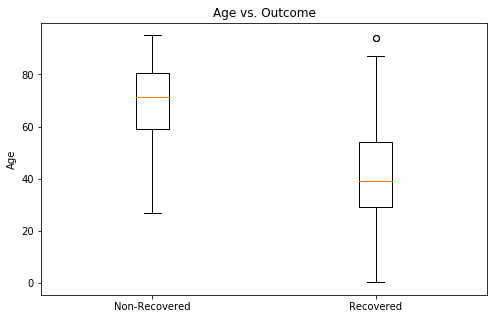

In [6]:
age_death = xtrain['que_paso'] == 0
age_rec = xtrain['que_paso'] == 1

xdeath = xtrain[age_death]
xrec = xtrain[age_rec]

age1 = xdeath['age']
age2 = xrec['age']

data = [age1, age2]
fig, ax = plt.subplots(figsize = (8,5))
ax.set_title('Age vs. Outcome')

ax.boxplot(data, labels = ['Non-Recovered', 'Recovered'])
ax.set_ylabel("Age")
plt.show()

In [7]:
xtrain2 = xtrain.drop('que_paso', axis = 1)

In [8]:
from sklearn.ensemble import RandomForestClassifier 

clf =  RandomForestClassifier(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True, random_state=42)

clf.fit(xtrain2, ytrain)

var_imp = clf.feature_importances_
var = xtrain2.columns

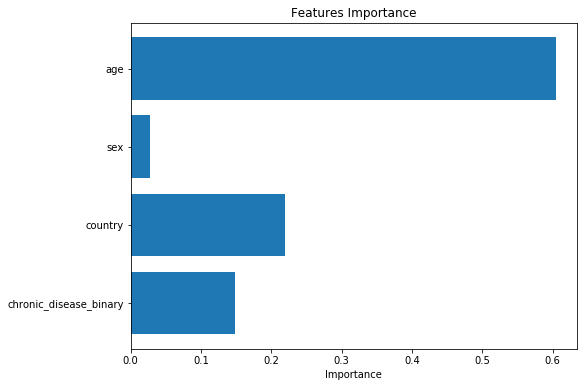

In [9]:
fig, ax = plt.subplots(figsize = (8,6))

y_pos = np.arange(len(var))

ax.barh(y_pos, var_imp, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(var)
ax.invert_yaxis() 
ax.set_xlabel('Importance')
ax.set_title('Features Importance')

plt.show()

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics

In [11]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as knc

clfs = {"SVM": SVC(gamma = 'auto'),
    "Random Forest": RandomForestClassifier(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True, random_state=42),
    "AdaBoost": AdaBoostClassifier(),
    "Naive Bayes": GaussianNB()}

In [12]:
def best_k(xtrain,ytrain,xtest,ytest):
    krange = range(1,25) # 24 possible k's
    scores = []
    
    for k in krange:
        knn = knc(n_neighbors = k)
        knn.fit(xtrain,ytrain)
        ypred = knn.predict(xtest)
        scores.append(metrics.accuracy_score(ytest,ypred))
    i = np.argmax(scores)
    return krange[i]

def knn(xtrain,ytrain,xtest,k):
    scaler = StandardScaler()
    scaler.fit(xtrain)
    scaler.fit(xtest)
    xtrain = scaler.transform(xtrain)
    xtest = scaler.transform(xtest)
    
    knn_class_tr = knc(n_neighbors = k).fit(xtrain, ytrain)
    y_pred = knn_class_tr.predict(xtest)
    return y_pred

In [15]:
def classifier(data, clfs_dict):
    selection = 0
    X = data.drop("que_paso", axis = 1)
    y = data.iloc[:,-1]
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.5)

    scaler = StandardScaler()
    scaler.fit(xtrain)
    scaler.fit(xtest)

    xtrain = scaler.transform(xtrain)
    xtest = scaler.transform(xtest)
    while selection != 6:
        print("1. KNN")
        print("2. SVM")
        print("3. Random Forest")
        print("4. AdaBoost")
        print("5. Naive Bayes")
        print("6. Quit")
        selection = int(input("Choose your ML method: "))

        if selection == 6:
            print("Goodbye!")
            break
            
        elif selection == 1:
            k = best_k(xtrain,ytrain,xtest,ytest)
            ypred = knn(xtrain,ytrain,xtest,k)
            fpr, tpr, thresholds = metrics.roc_curve(ytest, ypred)
            auc = round(metrics.auc(fpr,tpr),4)

            names = list(clfs_dict.keys())

            print("The AUC for KNN is", auc)
            plt.plot(fpr, tpr, 'r-', lw = 1)
            plt.plot([0, 1], [0, 1], color = 'navy', lw = 1, linestyle = '--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("K Nearest Neighbors")
            plt.show()

        else:
            ML = list(clfs_dict.values())
            clf = ML[selection - 2].fit(xtrain,ytrain)
            ypred = clf.predict(xtest)
            fpr, tpr, thresholds = metrics.roc_curve(ytest, ypred)
            auc = round(metrics.auc(fpr,tpr),4)

            names = list(clfs_dict.keys())

            print("The AUC for", names[selection - 2], "is", auc)
            plt.plot(fpr, tpr, 'r-', lw = 1)
            plt.plot([0, 1], [0, 1], color = 'navy', lw = 1, linestyle = '--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(names[selection - 2])
            plt.show()

    return auc

1. KNN
2. SVM
3. Random Forest
4. AdaBoost
5. Naive Bayes
6. Quit
Choose your ML method: 1
The AUC for KNN is 0.8525


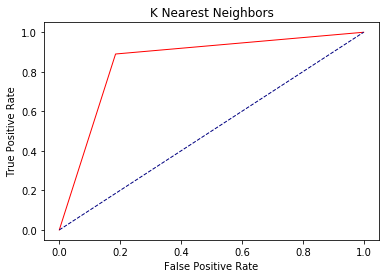

1. KNN
2. SVM
3. Random Forest
4. AdaBoost
5. Naive Bayes
6. Quit
Choose your ML method: 2
The AUC for SVM is 0.838


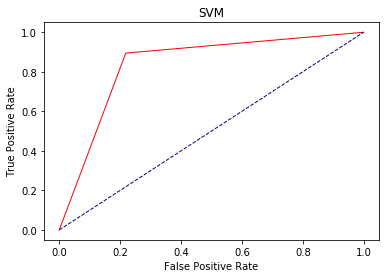

1. KNN
2. SVM
3. Random Forest
4. AdaBoost
5. Naive Bayes
6. Quit
Choose your ML method: 3
The AUC for Random Forest is 0.8445


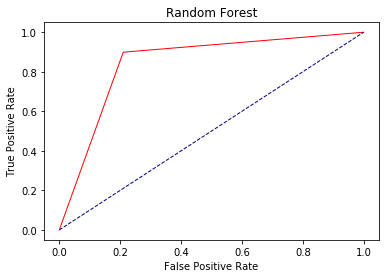

1. KNN
2. SVM
3. Random Forest
4. AdaBoost
5. Naive Bayes
6. Quit
Choose your ML method: 6
Goodbye!


In [16]:
auc = classifier(xtrain, clfs)